In [1]:
# simple generative adversarial network
# this version uses simple images, the MNIST dataset

In [1]:
# conventional PyTorch imports
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
import random
import pandas

In [3]:
import numpy
import matplotlib.pyplot as plt

In [4]:
# dataset class

class MnistDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        image_target = torch.zeros((10))
        image_target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, image_target
    
    def plot_image(self, index):
        arr = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
        pass
    
    pass


In [5]:
# subclass PyTorch dataset class, loads actual data, parses it into targets and pizel data
mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

# iterator for mnist_dataset
mnist_dataloader = DataLoader(mnist_dataset, batch_size=1, shuffle=False, num_workers=1)

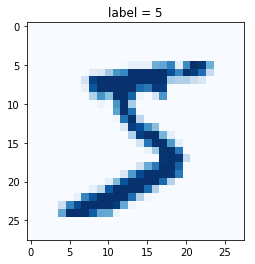

In [6]:
mnist_dataset.plot_image(0)

In [125]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [168]:
# classifier class

class Classifier(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
        
            
            nn.Conv2d(1, 1, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            
            View((1,25)),
            nn.Linear(25, 10),
            nn.Sigmoid()
            
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using Adam for better gradient descent
        self.optimiser = torch.optim.Adam(self.parameters())
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs.view(1, 1, 28, 28))
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs.view(1, 1, 28, 28))
        
        # calculate error
        loss = self.error_function(outputs.view(10), targets.view(10))
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [169]:
# scratch
C = Classifier()
image_data = mnist_dataset[record][1]
z = C.forward(image_data)
z.shape

torch.Size([1, 10])

In [177]:
# train classifier

C = Classifier()

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataloader:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 3
training epoch 2 of 3
training epoch 3 of 3


In [178]:
# saving and loading neural network state so you don't have to keep training

#C.save("mnist1.pt")

#C = Classifier()
#C.load("mnist1.pt")

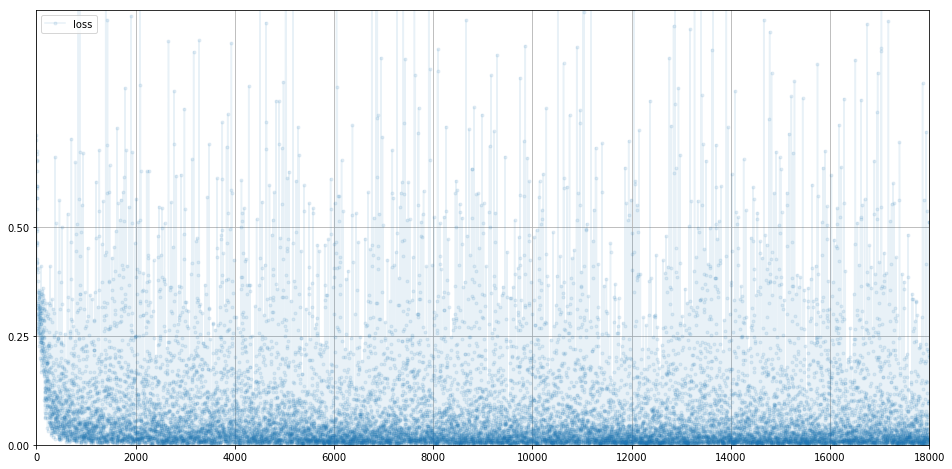

In [179]:
# plot classifier error

C.plot_progress()

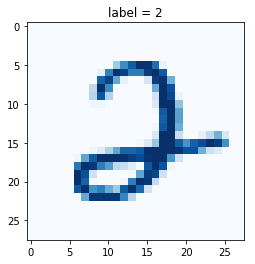

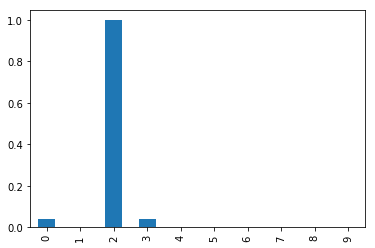

In [180]:
# test classifier

# pick a record
record = 16

# see the image and what the correct label should be
mnist_dataset.plot_image(record)

# visualise the answer given by the neural network
image_data = mnist_dataset[record][1]
pandas.DataFrame(C.forward(image_data).view(10,1).detach().numpy()).plot(kind='bar', legend=False)

In [181]:
# test trained neural network on training data

# subclass PyTorch dataset class, loads actual data, parses it into targets and pizel data
mnist_test_dataset = MnistDataset('mnist_data/mnist_test.csv')

# iterator for mnist_dataset
mnist_test_dataloader = DataLoader(mnist_test_dataset, batch_size=1, shuffle=False, num_workers=1)

score = 0;
items = 0;

for label, image_data_tensor, target_tensor in mnist_test_dataloader:
    answer = C.forward(image_data_tensor).view(10,1).detach().numpy()
    if (answer.argmax() == label):
        score += 1;
        pass
    items += 1;
    
    pass

print(score, items, score/items)

8808 10000 0.8808
